# Project : Emotion Detection With FER 2013

loading the Librarires

In [2]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline


haars cascade is loaded into the notebook

In [3]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

[ERROR:0@386.072] global persistence.cpp:566 open Can't open file: 'haarcascades/haarcascade_frontalface_default.xml' in read mode


use this function to detect face


In [6]:
def detect_face(img):
    face_img = img.copy()
  
    face_rects = face_cascade.detectMultiScale(face_img, minNeighbors=1) 
    
    for (x,y,w,h) in face_rects: 
        cv2.rectangle(face_img, (x,y), (x+w,y+h), (255,255,255), 10) 
        
    return face_img
    

reading an Image

In [8]:
def turn_to_gray(im_path):
    image = cv2.imread(im_path) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray


In [9]:
from pathlib import Path

root = Path("D:/University/Massey University/2nD year Sem 2/Big Data Processing and Applied Machine Learning/Assignment 03/data/train/angry")

image_names = ["Training_63181.jpg","Training_9402163.jpg","Training_99531165.jpg","Training_81730099.jpg", "Training_8861363.jpg"]
image_paths = []

for item in image_names:
    image_path = root / item  
    image_paths.append(image_path)

print(image_paths)


[WindowsPath('D:/University/Massey University/2nD year Sem 2/Big Data Processing and Applied Machine Learning/Assignment 03/data/train/angry/Training_63181.jpg'), WindowsPath('D:/University/Massey University/2nD year Sem 2/Big Data Processing and Applied Machine Learning/Assignment 03/data/train/angry/Training_9402163.jpg'), WindowsPath('D:/University/Massey University/2nD year Sem 2/Big Data Processing and Applied Machine Learning/Assignment 03/data/train/angry/Training_99531165.jpg'), WindowsPath('D:/University/Massey University/2nD year Sem 2/Big Data Processing and Applied Machine Learning/Assignment 03/data/train/angry/Training_81730099.jpg'), WindowsPath('D:/University/Massey University/2nD year Sem 2/Big Data Processing and Applied Machine Learning/Assignment 03/data/train/angry/Training_8861363.jpg')]


visualizing it 

In [11]:
detections = []
for item in image_paths:
    gray = turn_to_gray(item)
    det = detect_face(gray)
    detections.append(det)

calling the detect function

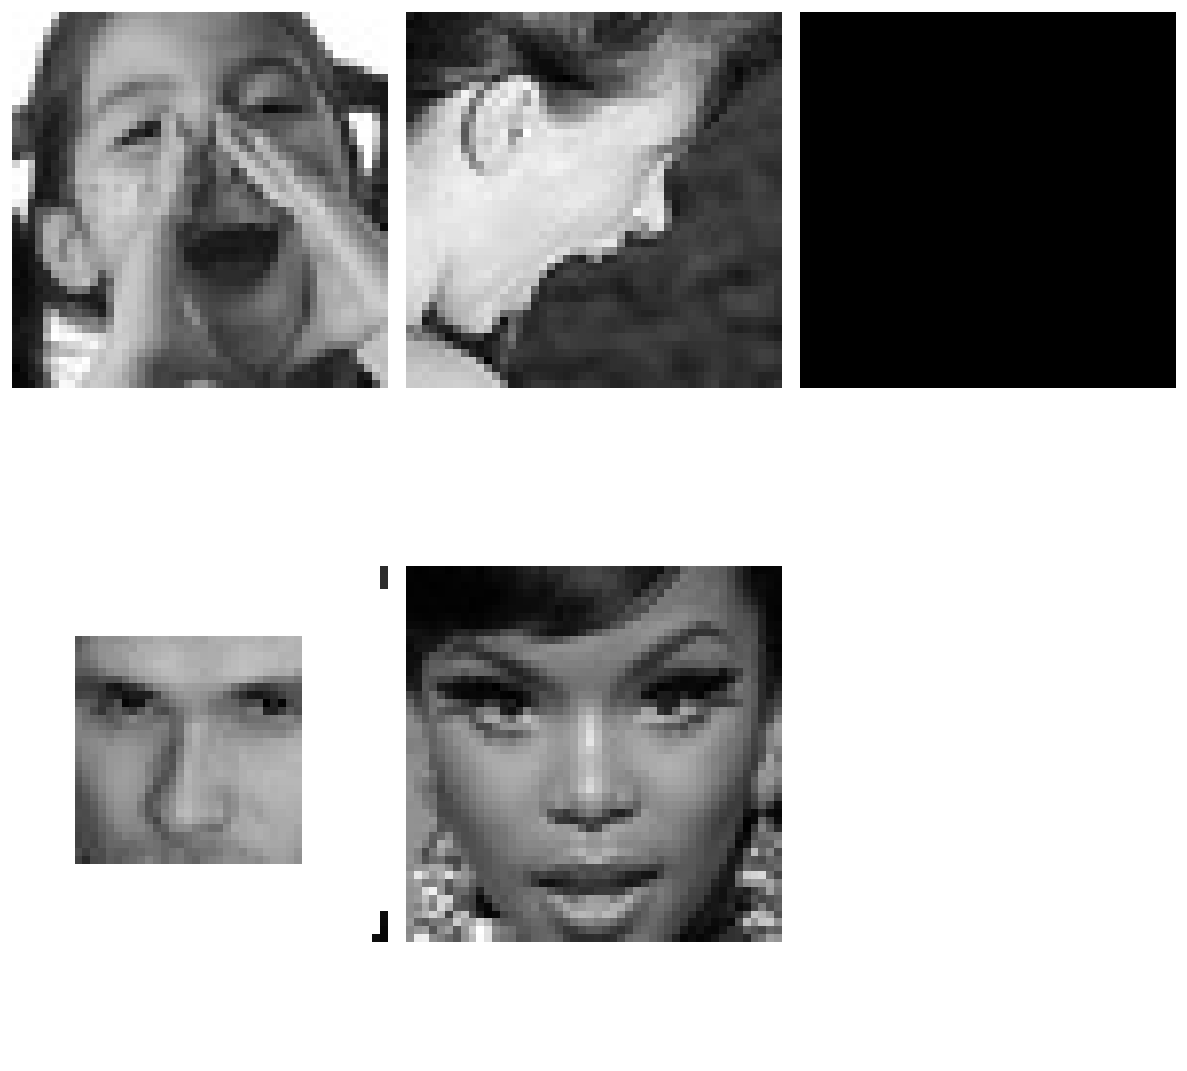

In [281]:
import matplotlib.pyplot as plt

# assume detections is a list of 48x48 arrays (dtype=uint8)
num_images = len(detections)
cols = 3  # number of columns
rows = (num_images + cols - 1) // cols  # auto-calculate rows

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for ax, img in zip(axes.flat, detections):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

# hide any extra subplots (if detections not perfectly divisible by cols)
for ax in axes.flat[len(detections):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


Out of all the images chosen only one was detected as a face, first image with the girl covering her face and the second image with the man who has his face turned and the black image are all bad data, however thw woman in the final image is good data , but the haars cascade hasn't detected this properly. 

However, the fourth image has been detected properly

Use this function to crop the images

In [15]:
def crop_bbox(img, x, y, w, h, pad=0):
    H, W = img.shape[:2]
    x1 = max(0, x - pad)
    y1 = max(0, y - pad)
    x2 = min(W, x + w + pad)
    y2 = min(H, y + h + pad)
    return img[y1:y2, x1:x2]

In [16]:
def detect_face(img, minN):
    face_img = img.copy()
  
    face_rects = face_cascade.detectMultiScale(face_img, minNeighbors=minN) 
    
    for (x,y,w,h) in face_rects: 
        cv2.rectangle(face_img, (x,y), (x+w,y+h), (255,255,255), 10) 
        
    return face_rects

In [17]:
def detect_faces_robust(img_bgr,scaleFactor=1.08, minNeighbors=1, minSize=(18,18),clahe=True, upsample_if_small=True):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    if clahe:
        gray = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4)).apply(gray)
    scale_back = 1.0
    if upsample_if_small and (gray.shape[0] < 200 or gray.shape[1] < 200):
        gray = cv2.resize(gray, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
        scale_back = 0.5
    faces = face_cascade.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors,minSize=minSize, flags=cv2.CASCADE_SCALE_IMAGE)

    boxes = []
    for (x,y,w,h) in faces:
        if scale_back != 1.0:
            x = int(x*scale_back); y = int(y*scale_back)
            w = int(w*scale_back); h = int(h*scale_back)
        boxes.append((x,y,w,h))
    return boxes

In [53]:
import os,csv
from tqdm import tqdm

def filter_dataset_with_haar(in_root, out_root,resize_to=(48,48), pad=4, keep_largest_only=True,  
    save_rejects=True, rejects_subdir="_rejects", force_grayscale=True, write_manifest=True):
    in_root  = Path(in_root)
    out_root = Path(out_root)
    out_root.mkdir(parents=True, exist_ok=True)
    rej_root = out_root / rejects_subdir    
    if save_rejects:
        rej_root.mkdir(parents=True, exist_ok=True)

    kept, rejected = 0, 0

    exts = {".jpg",".jpeg",".png",".bmp",".webp"}
    img_paths = [p for p in in_root.rglob("*") if p.suffix.lower() in exts]
    for p in tqdm(img_paths, desc="Filtering"):
        
        rel = p.relative_to(in_root)
        label = rel.parent.name 
        img = cv2.imread(str(p))
        if img is None: 
            rejected += 1
            continue
        boxes = detect_faces_robust(img)  
        if not boxes:
            rejected += 1
            if save_rejects:
                (rej_root/label).mkdir(parents=True, exist_ok=True)
                cv2.imwrite(str((rej_root/label/f"{p.stem}_noface{p.suffix}")), img)
            continue
        sel = boxes
        if keep_largest_only:
            sel = [max(boxes, key=lambda b: b[2]*b[3])]
        dst_dir = out_root/label
        dst_dir.mkdir(parents=True, exist_ok=True)
        for i,(x,y,w_,h_) in enumerate(sel):
            crop = crop_bbox(img, x,y,w_,h_, pad=pad)
            if resize_to:
                crop = cv2.resize(crop, resize_to, interpolation=cv2.INTER_AREA)
            if force_grayscale:
                crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY) 
            fname = f"{p.stem}_face{i}.png"
            out_path = dst_dir/fname
            cv2.imwrite(str(out_path), crop)
            kept += 1
    print(f"Done. Kept: {kept}  |  Rejected: {rejected}  |  Output -> {out_root}")


In [55]:
filter_dataset_with_haar(in_root = r"data/train", out_root = r"new_data/train")

Filtering: 100%|█████████████████████████████████████████████████████████████████| 28709/28709 [07:10<00:00, 66.75it/s]

Done. Kept: 19734  |  Rejected: 8975  |  Output -> new_data\train


In [56]:
filter_dataset_with_haar(in_root = r"data/test", out_root = r"new_data/test")

Filtering: 100%|███████████████████████████████████████████████████████████████████| 7178/7178 [01:50<00:00, 65.19it/s]

Done. Kept: 4893  |  Rejected: 2285  |  Output -> new_data\test


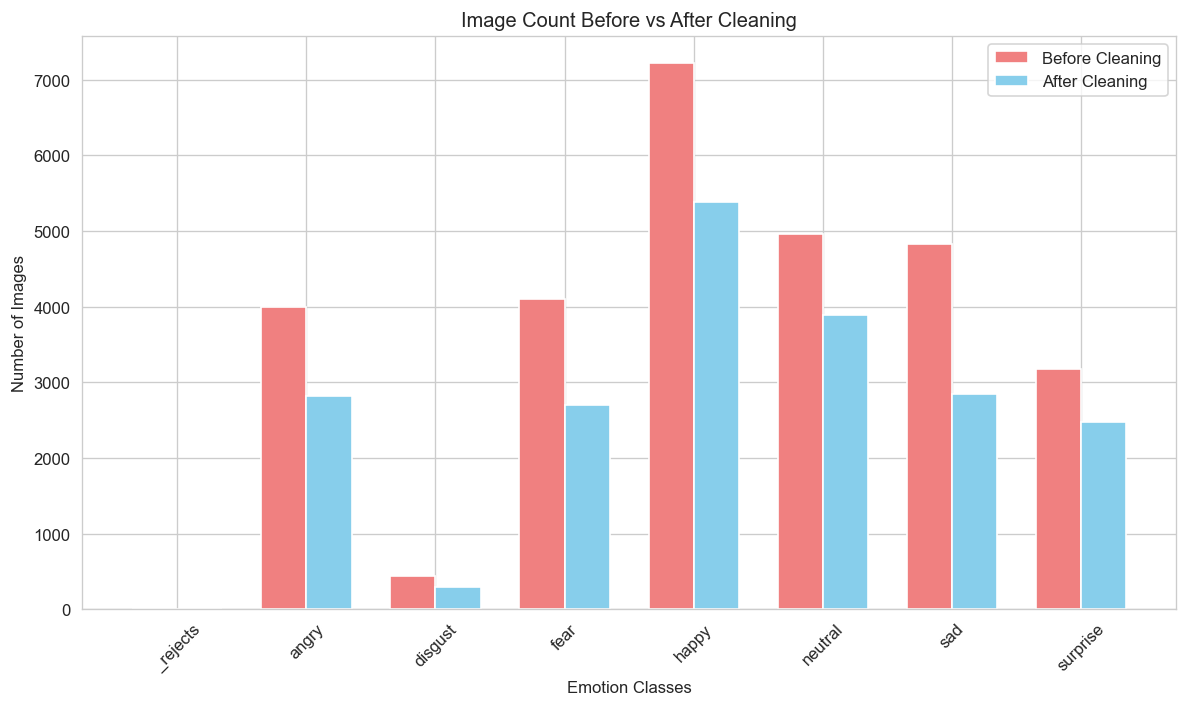

In [289]:
import os
import matplotlib.pyplot as plt
import numpy as np

# --- Define base paths ---
before_path = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\data\train"
after_path  = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\new_data\train"

def count_images(base_path):
    folder_counts = {}
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            count = len([
                f for f in os.listdir(folder_path)
                if os.path.isfile(os.path.join(folder_path, f))
            ])
            folder_counts[folder] = count
    return folder_counts

# --- Count images before and after cleaning ---
before_counts = count_images(before_path)
after_counts  = count_images(after_path)

# --- Ensure both have the same folder order ---
all_classes = sorted(set(before_counts.keys()) | set(after_counts.keys()))
before_values = [before_counts.get(c, 0) for c in all_classes]
after_values  = [after_counts.get(c, 0) for c in all_classes]

# --- Create double bar chart ---
x = np.arange(len(all_classes))  # positions
width = 0.35  # bar width

plt.figure(figsize=(10,6))
plt.bar(x - width/2, before_values, width, label='Before Cleaning', color='lightcoral')
plt.bar(x + width/2, after_values,  width, label='After Cleaning', color='skyblue')

plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Image Count Before vs After Cleaning")
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


it seems that almost one third of the data has been deleted with the haars cascade it might make it harder for our machine learning models to pick up the patterns in the data . another data foltering method should be used 

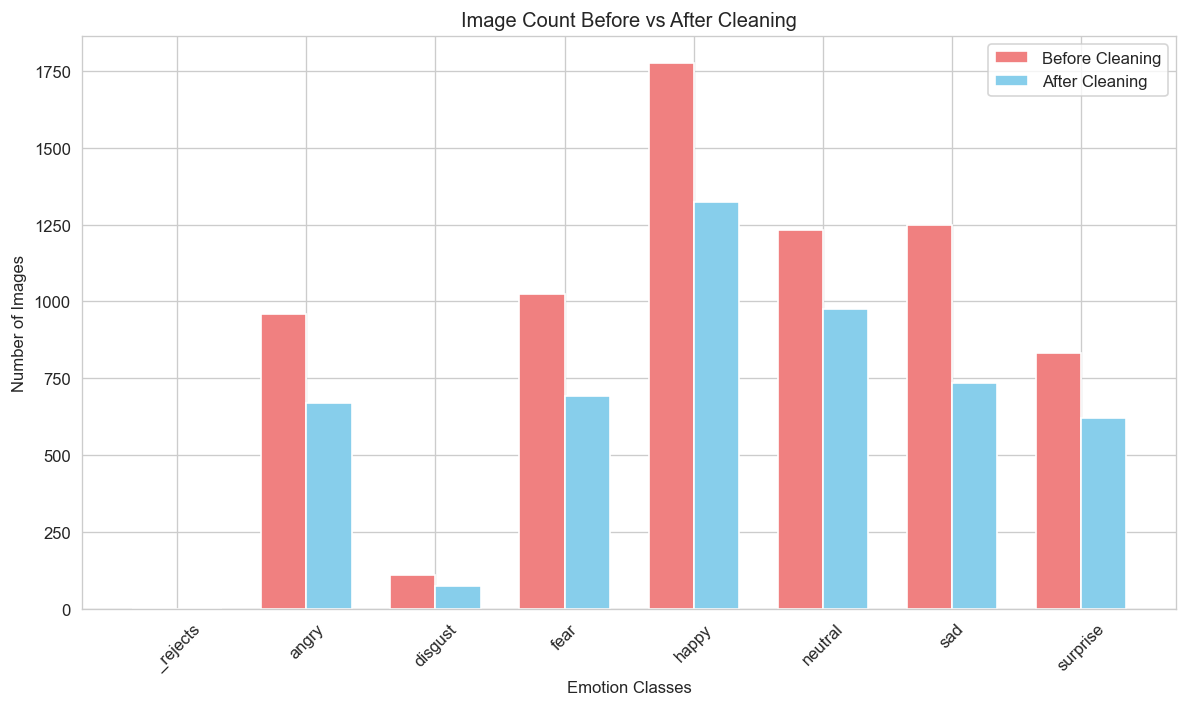

In [291]:
import os
import matplotlib.pyplot as plt
import numpy as np

# --- Define base paths ---
before_path = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\data\test"
after_path  = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\new_data\test"

def count_images(base_path):
    folder_counts = {}
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            count = len([
                f for f in os.listdir(folder_path)
                if os.path.isfile(os.path.join(folder_path, f))
            ])
            folder_counts[folder] = count
    return folder_counts

# --- Count images before and after cleaning ---
before_counts = count_images(before_path)
after_counts  = count_images(after_path)

# --- Ensure both have the same folder order ---
all_classes = sorted(set(before_counts.keys()) | set(after_counts.keys()))
before_values = [before_counts.get(c, 0) for c in all_classes]
after_values  = [after_counts.get(c, 0) for c in all_classes]

# --- Create double bar chart ---
x = np.arange(len(all_classes))  # positions
width = 0.35  # bar width

plt.figure(figsize=(10,6))
plt.bar(x - width/2, before_values, width, label='Before Cleaning', color='lightcoral')
plt.bar(x + width/2, after_values,  width, label='After Cleaning', color='skyblue')

plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Image Count Before vs After Cleaning")
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Almost one third of the test data has also been deleted. 

Using a mtcnn model to clean the data

In [370]:
from mtcnn.mtcnn import MTCNN

img_path = image_paths[-1] 
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(img_path)

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

detector = MTCNN()
results = detector.detect_faces(rgb)

for r in results:
    x, y, w, h = r["box"]
    cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)
    for (lx, ly) in r["keypoints"].values():
        cv2.circle(img, (lx, ly), 3, (0,0,255), -1)

print(f"Found {len(results)} face(s)")



Found 1 face(s)


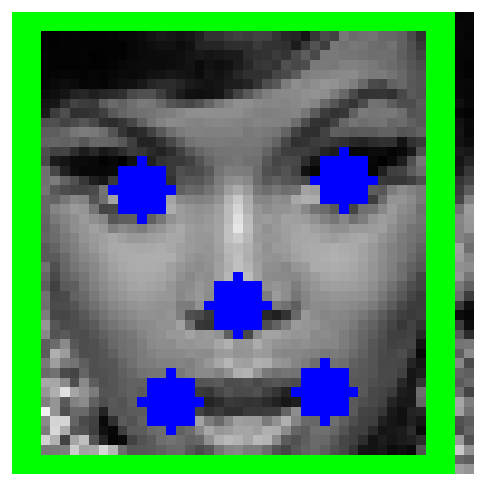

In [374]:
plt.imshow(img)
plt.axis("off")
plt.show()

it seems the picture of the woman which wasn't recognized by the haarscascade is recognized by the MTCNN Architecture 

In [ ]:
def rotate_and_crop(img, box, keypoints, eye_target_y=40, out_size=(112,112)):
    (x, y, w, h) = box
    left_eye  = keypoints["left_eye"]
    right_eye = keypoints["right_eye"]
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = math.degrees(math.atan2(dy, dx))
    center = (x + w//2, y + h//2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    pad = int(0.25 * max(w, h))
    x1 = max(0, x - pad); y1 = max(0, y - pad)
    x2 = min(rotated.shape[1], x + w + pad); y2 = min(rotated.shape[0], y + h + pad)
    crop = rotated[y1:y2, x1:x2]
    if crop.size == 0:
        return None
    return cv2.resize(crop, out_size, interpolation=cv2.INTER_AREA)

In [ ]:
in_dir  = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\data\train")   
out_dir = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\train")
out_dir.mkdir(parents=True, exist_ok=True)

detector = MTCNN()
img_exts = {".jpg"}

count = 0
for p in in_dir.rglob("*"):
    if p not in img_exts:
        continue

    bgr = cv2.imread(str(p))
    if bgr is None:
        continue
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    detections = detector.detect_faces(rgb)
    for i, det in enumerate(detections):
        crop = rotate_and_crop(bgr, det["box"], det["keypoints"])
        if crop is None:
            continue
        rel_path = p.relative_to(in_dir)  
        out_subdir = out_dir / rel_path.parent  
        out_subdir.mkdir(parents=True, exist_ok=True)

        out_path = out_subdir / f"{p.stem}_face{i}.jpg"
        cv2.imwrite(str(out_path), crop)
        count += 1


print(f"Saved {count} aligned face crop(s) to: {out_dir}")


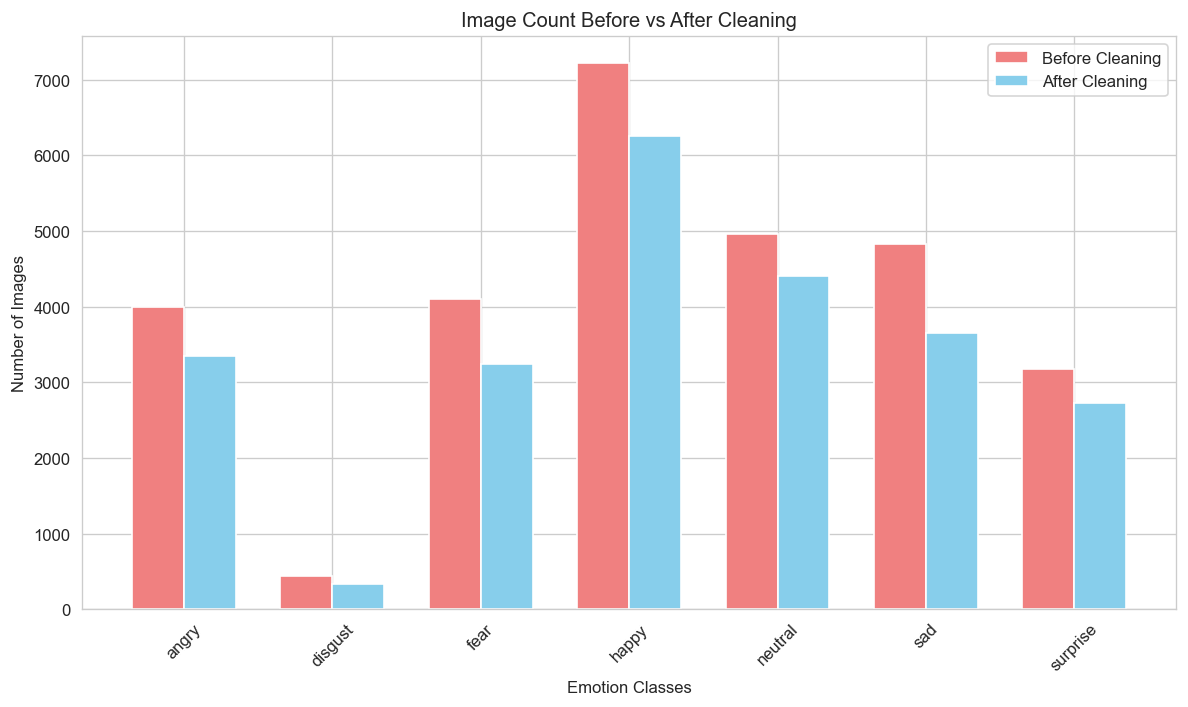

In [360]:
import os
import matplotlib.pyplot as plt
import numpy as np

# --- Define base paths ---
before_path = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\data\train"
after_path  = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\train"

def count_images(base_path):
    folder_counts = {}
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            count = len([
                f for f in os.listdir(folder_path)
                if os.path.isfile(os.path.join(folder_path, f))
            ])
            folder_counts[folder] = count
    return folder_counts

# --- Count images before and after cleaning ---
before_counts = count_images(before_path)
after_counts  = count_images(after_path)

# --- Ensure both have the same folder order ---
all_classes = sorted(set(before_counts.keys()) | set(after_counts.keys()))
before_values = [before_counts.get(c, 0) for c in all_classes]
after_values  = [after_counts.get(c, 0) for c in all_classes]

# --- Create double bar chart ---
x = np.arange(len(all_classes))  # positions
width = 0.35  # bar width

plt.figure(figsize=(10,6))
plt.bar(x - width/2, before_values, width, label='Before Cleaning', color='lightcoral')
plt.bar(x + width/2, after_values,  width, label='After Cleaning', color='skyblue')

plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Image Count Before vs After Cleaning")
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

A lot less data are delted with use of MTCNN architecture to filter data

In [ ]:
in_dir  = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\data\test")   # << change this
out_dir = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\test")
out_dir.mkdir(parents=True, exist_ok=True)

count = 0
for p in in_dir.rglob("*"):
    if p not in img_exts:
        continue

    bgr = cv2.imread(str(p))
    if bgr is None:
        continue
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    detections = detector.detect_faces(rgb)
    for i, det in enumerate(detections):
        crop = rotate_and_crop(bgr, det["box"], det["keypoints"])
        if crop is None:
            continue

        rel_path = p.relative_to(in_dir)  
        out_subdir = out_dir / rel_path.parent  
        out_subdir.mkdir(parents=True, exist_ok=True)

        out_path = out_subdir / f"{p.stem}_face{i}.jpg"
        cv2.imwrite(str(out_path), crop)
        count += 1

print(f"Saved {count} aligned face crop(s) to: {out_dir}")


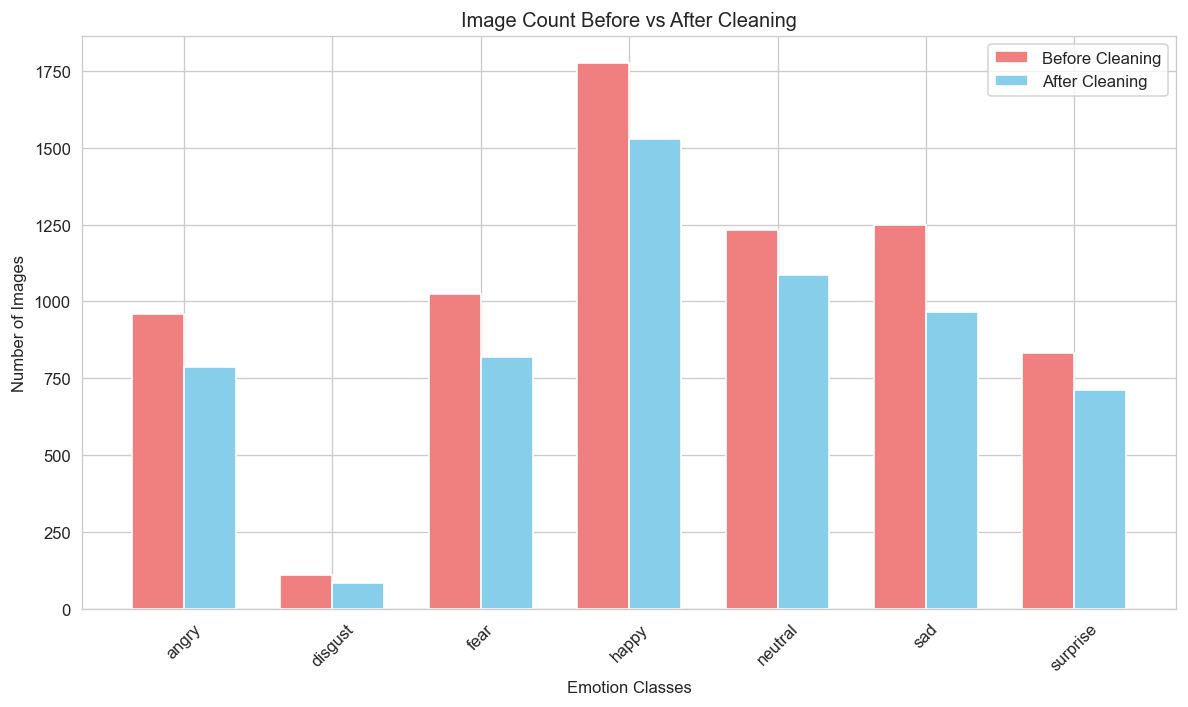

In [362]:
import os
import matplotlib.pyplot as plt
import numpy as np

# --- Define base paths ---
before_path = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\data\test"
after_path  = r"D:\University\Massey University\2nd year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\test"

def count_images(base_path):
    folder_counts = {}
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            count = len([
                f for f in os.listdir(folder_path)
                if os.path.isfile(os.path.join(folder_path, f))
            ])
            folder_counts[folder] = count
    return folder_counts

# --- Count images before and after cleaning ---
before_counts = count_images(before_path)
after_counts  = count_images(after_path)

# --- Ensure both have the same folder order ---
all_classes = sorted(set(before_counts.keys()) | set(after_counts.keys()))
before_values = [before_counts.get(c, 0) for c in all_classes]
after_values  = [after_counts.get(c, 0) for c in all_classes]

# --- Create double bar chart ---
x = np.arange(len(all_classes))  # positions
width = 0.35  # bar width

plt.figure(figsize=(10,6))
plt.bar(x - width/2, before_values, width, label='Before Cleaning', color='lightcoral')
plt.bar(x + width/2, after_values,  width, label='After Cleaning', color='skyblue')

plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Image Count Before vs After Cleaning")
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Implementing a Random Forest Model on the Data

Wavelet transformation will be used for feature extraction

In [61]:
def to_uint8(im):
    im = im.astype(np.float32)
    im -= im.min()
    if im.max() > 0:
        im /= im.max()
    return (im * 255).astype(np.uint8)

In [90]:
def resize_to_w(img, width):
    scale = width / img.shape[1]
    return cv2.resize(img, (width, int(img.shape[0]*scale)), interpolation=cv2.INTER_AREA)

In [92]:
import pywt


def wavelet_vstack(image_bgr, wavelet="db2", level=1):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    cA, (cH, cV, cD) = pywt.dwt2(gray, wavelet=wavelet)
    cA_v = to_uint8(cA)
    cH_v = to_uint8(np.abs(cH))
    cV_v = to_uint8(np.abs(cV))
    cD_v = to_uint8(np.abs(cD))
    h, w = gray.shape
    cA_v = resize_to_w(cA_v,w)
    cH_v = resize_to_w(cH_v,w)
    cV_v = resize_to_w(cV_v,w)
    cD_v = resize_to_w(cD_v,w)
    orig = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cA_c = cv2.cvtColor(cA_v, cv2.COLOR_GRAY2BGR)
    cH_c = cv2.cvtColor(cH_v, cv2.COLOR_GRAY2BGR)
    cV_c = cv2.cvtColor(cV_v, cv2.COLOR_GRAY2BGR)
    cD_c = cv2.cvtColor(cD_v, cv2.COLOR_GRAY2BGR)

    vs = np.vstack([orig, cA_c, cH_c, cV_c, cD_c])
    return vs





In [94]:
in_dir  = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\train")
out_dir = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\wave\train")
out_dir.mkdir(parents=True, exist_ok=True)
valid_exts = {".jpg"}
for p in in_dir.rglob("*"):
    if p.suffix.lower() in valid_exts:
        img = cv2.imread(str(p))
        if img is None: 
            continue
        rel_path = p.relative_to(in_dir)
        save_folder = out_dir / rel_path.parent
        save_folder.mkdir(parents=True, exist_ok=True)
        stacked = wavelet_vstack(img, wavelet="db2", level=1)
        out_path = save_folder / f"{p.stem}_wavelet_stack.jpg"
        cv2.imwrite(str(out_path), stacked)

print("Saved vertical stacks to:", out_dir)

Saved vertical stacks to: D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\wave\train


In [95]:

in_dir  = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\test")
out_dir = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\wave\test")
out_dir.mkdir(parents=True, exist_ok=True)

valid_exts = {".jpg"}

for p in in_dir.rglob("*"):
    if p.suffix.lower() in valid_exts:
        img = cv2.imread(str(p))
        if img is None: 
            continue
        rel_path = p.relative_to(in_dir)
        save_folder = out_dir / rel_path.parent
        save_folder.mkdir(parents=True, exist_ok=True)

        stacked = wavelet_vstack(img, wavelet="db2", level=1)
        out_path = save_folder / f"{p.stem}_wavelet_stack.jpg"
        cv2.imwrite(str(out_path), stacked)

print("Saved vertical stacks to:", out_dir)


Saved vertical stacks to: D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\wave\test


In [96]:

def extract_wavelet_features(img_path, wavelet="db2", level=1):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (64,64))
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)
    cA, detail_coeffs = coeffs[0], coeffs[1:]  
    features = [cA.flatten()]
    for (cH, cV, cD) in detail_coeffs:
        features.extend([cH.flatten(), cV.flatten(), cD.flatten()])
    return np.concatenate(features) 


In [97]:

data_dir = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\wave\train")

X, y = [], []
for folder in data_dir.iterdir():
    if folder.is_dir():
        label = folder.name
        for img_path in folder.glob("*.jpg"):
            feats = extract_wavelet_features(img_path)
            if feats is not None:
                X.append(feats)
                y.append(label)

X = np.array(X)
y = np.array(y)

print("Feature matrix:", X.shape, "Labels:", y.shape)


Feature matrix: (20096, 4356) Labels: (20096,)


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
print("Random Forest Results:\n", classification_report(y_test, rf.predict(X_test)))


Random Forest Results:
               precision    recall  f1-score   support

       angry       0.56      0.19      0.29       564
        fear       0.65      0.17      0.27       540
       happy       0.46      0.89      0.61      1075
     neutral       0.40      0.57      0.47       777
         sad       0.50      0.12      0.20       569
    surprise       0.73      0.55      0.63       495

    accuracy                           0.48      4020
   macro avg       0.55      0.42      0.41      4020
weighted avg       0.53      0.48      0.43      4020



# Implementing a Base Line CNN Architecture on the Data Set

Implementing a Baseline CNN Model 

In [2]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/dtasets/Assignment 03/mtcnnBybasuru/train",        
    image_size=(48, 48),   
    batch_size=32,
    label_mode = "categorical"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/dtasets/Assignment 03/mtcnnBybasuru/test",       
    image_size=(48, 48),
    batch_size=32,
    label_mode = "categorical"
)


2025-10-09 23:04:15.918318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760051056.552785      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760051056.679311      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 23952 files belonging to 7 classes.


I0000 00:00:1760051092.727025      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760051092.727855      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 5986 files belonging to 7 classes.


Implementing a Baseline CNN Model 

In [3]:
class_names = train_ds.class_names
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [4]:
from tensorflow.keras import layers, models

num_classes = len(class_names)
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(48,48,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,423 (1.36 MB)

 Trainable params: 356,423 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])


In [6]:
history_1 = model.fit(train_ds,validation_data=test_ds,epochs=20)


Epoch 1/20


I0000 00:00:1760051102.593013     114 service.cc:148] XLA service 0x7d08e4009440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760051102.594658     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760051102.594684     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760051103.022931     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


 10/749 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.1669 - loss: 1.9356

I0000 00:00:1760051106.730986     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


749/749 ━━━━━━━━━━━━━━━━━━━━ 60s 71ms/step - accuracy: 0.2515 - loss: 1.8177 - val_accuracy: 0.4093 - val_loss: 1.5411
Epoch 2/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4080 - loss: 1.5242 - val_accuracy: 0.4815 - val_loss: 1.3660
Epoch 3/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4702 - loss: 1.3845 - val_accuracy: 0.4983 - val_loss: 1.3198
Epoch 4/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4975 - loss: 1.3018 - val_accuracy: 0.5311 - val_loss: 1.2313
Epoch 5/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5240 - loss: 1.2406 - val_accuracy: 0.5388 - val_loss: 1.1953
Epoch 6/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5447 - loss: 1.1847 - val_accuracy: 0.5448 - val_loss: 1.1853
Epoch 7/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5633 - loss: 1.1386 - val_accuracy: 0.5525 - val_loss: 1.1565
Epoch 8/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5858 - loss: 1.1003 - val_accurac

In [7]:
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc:.2f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5751 - loss: 1.3053
Test accuracy: 0.57


In [8]:
from tensorflow.keras.preprocessing import image
x = image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)
pred = model.predict(x)
class_id = np.argmax(pred)


NameError: name 'img' is not defined

In [9]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

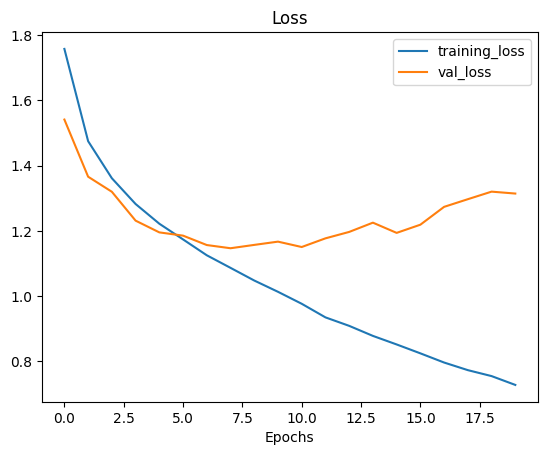

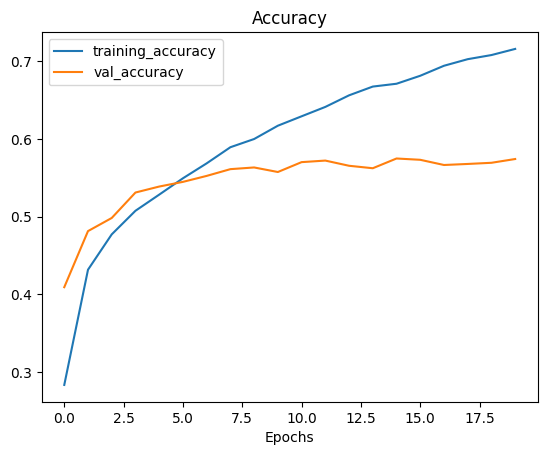

In [10]:
# Check out the loss curves of model_4
plot_loss_curves(history_1)
plt.show()

it seems the baseline model is overfitting the data as the validation accuracy is flattening out after the fifth epoch

# Using the Mini-xception CNN Architectire Extracted from Git Hub

In [11]:
import tensorflow as tf

img_size = (48, 48)
batch_size = 64

train_ds = tf.keras.utils.image_dataset_from_directory("/kaggle/input/dtasets/Assignment 03/mtcnnBybasuru/train",labels="inferred",label_mode="categorical",        
    image_size=img_size,batch_size=batch_size,shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory("/kaggle/input/dtasets/Assignment 03/mtcnnBybasuru/test", labels="inferred",label_mode="categorical",
    image_size=img_size,batch_size=batch_size,shuffle=False)





Found 23952 files belonging to 7 classes.
Found 5986 files belonging to 7 classes.


In [12]:
def scale_pixels(x, y):
    return tf.cast(x, tf.float32) / 255.0, y



In [13]:
train_ds = train_ds.map(scale_pixels).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(scale_pixels).prefetch(tf.data.AUTOTUNE)

this function was extracted from Git Hub

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation,
                                     SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D)
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
def build_minixception(input_shape, num_classes, l2_reg=0.01):
    """Function for instantiating an Mini-Xception model.

    # Arguments
        input_shape: List corresponding to the input shape
            of the model.
        num_classes: Integer.
        l2_reg. Float. L2 regularization used
            in the convolutional kernels.

    # Returns
        Tensorflow-Keras model.
    """

    regularization = l2(l2_reg)

    # base
    img_input = Input(input_shape)
    x = Conv2D(5, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(1, 1),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model


In [24]:
model = build_minixception(input_shape=(48, 48, 3),  num_classes=7)

In [25]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",   
    metrics=["accuracy"]
)


In [26]:
history_2 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20
)


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.3364 - loss: 1.9118 - val_accuracy: 0.1874 - val_loss: 2.1435
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.4795 - loss: 1.5271 - val_accuracy: 0.4103 - val_loss: 1.7456
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.5214 - loss: 1.3979 - val_accuracy: 0.4823 - val_loss: 1.4744
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.5414 - loss: 1.3180 - val_accuracy: 0.4460 - val_loss: 1.6485
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5721 - loss: 1.2502 - val_accuracy: 0.5247 - val_loss: 1.4769
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5789 - loss: 1.2102 - val_accuracy: 0.4784 - val_loss: 1.5582
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5927 - loss: 1.1736 - val_accuracy: 0.4843 - val_loss: 1.5332
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.6053 - loss: 1.1364 - 

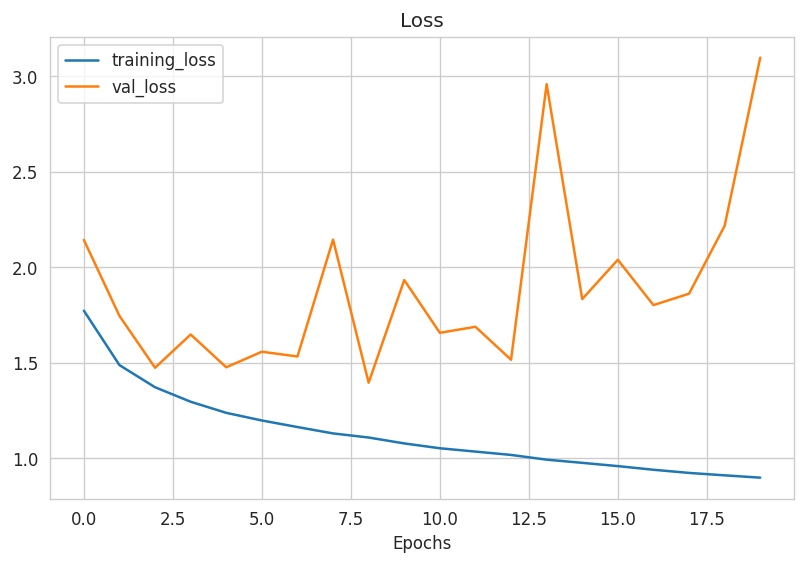

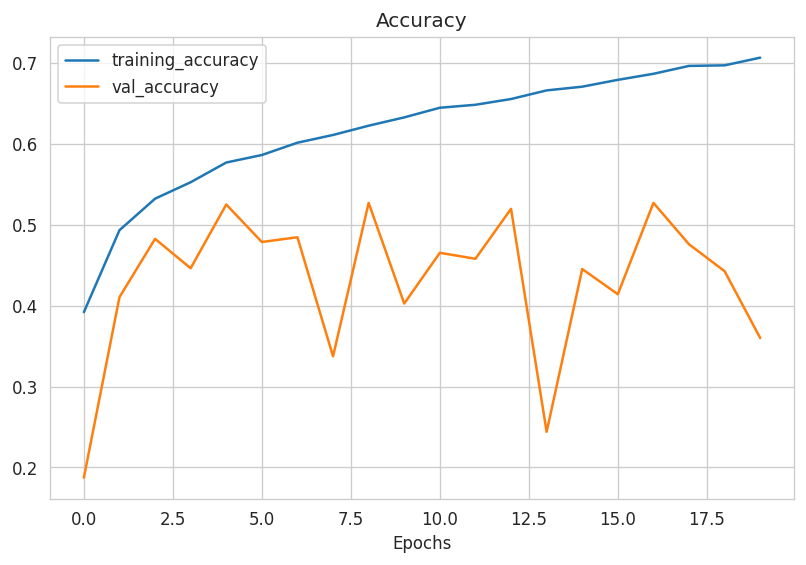

In [27]:
plot_loss_curves(history_2)
plt.show()

# Training convnext_tiny.fb_in22k

In [3]:
import random, time, math
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler

from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image

import timm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [4]:
import torch

# Detect and set the correct device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", DEVICE)


✅ Using device: cuda


In [5]:
#DATA_DIR = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn")

TRAIN_DIR = "/kaggle/input/dtasets/Assignment 03/mtcnnBybasuru/train"
TEST_DIR  ="/kaggle/input/dtasets/Assignment 03/mtcnnBybasuru/test"

In [6]:
IMG_SIZE = 224
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])



In [7]:
valid_exts = {".jpg"}
def is_image_file(path: str) -> bool:
    return Path(path).suffix.lower() in valid_exts

In [8]:
from pathlib import Path


In [9]:
train_ds = ImageFolder(TRAIN_DIR, transform=train_tfm, is_valid_file=is_image_file)
test_ds  = ImageFolder(TEST_DIR,  transform=test_tfm,  is_valid_file=is_image_file)

In [10]:
CLASSES = train_ds.classes
NUM_CLASSES = len(CLASSES)

In [11]:
labels = np.array(train_ds.targets)
counts = np.array([np.sum(labels == i) for i in range(NUM_CLASSES)], dtype=np.float32)
print("Per-class counts:", dict(zip(CLASSES, counts.astype(int))))


Per-class counts: {'angry': 3351, 'disgust': 327, 'fear': 3244, 'happy': 6249, 'neutral': 4407, 'sad': 3653, 'surprise': 2721}


In [12]:
weights = counts.sum() / (counts * NUM_CLASSES)
class_weights = torch.tensor(weights, dtype=torch.float32, device = DEVICE)
print("Class weights:", dict(zip(CLASSES, weights.round(3))))

Class weights: {'angry': 1.021, 'disgust': 10.464, 'fear': 1.055, 'happy': 0.548, 'neutral': 0.776, 'sad': 0.937, 'surprise': 1.258}


In [13]:

BATCH_SIZE   = 64
NUM_WORKERS  = 2
sample_w = weights[labels]
sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True)

In [14]:

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

In [15]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [16]:
pip install hf_xet

Note: you may need to restart the kernel to use updated packages.


In [17]:
import torch
import timm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", DEVICE)

BACKBONE = "convnext_tiny.fb_in22k"
model = timm.create_model(BACKBONE, pretrained=True, num_classes=NUM_CLASSES)
model.to(DEVICE)

BASE_LR = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=3e-6)

# Enable mixed precision only when using GPU
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))


✅ Using device: cuda


model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

/tmp/ipykernel_37/1040473749.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))


In [18]:
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

In [19]:
def train_one_epoch(model, loader, criterion):
    model.train()
    total_loss, total_acc, total_n = 0.0, 0.0, 0

    pbar = tqdm(loader, leave=False, desc="train")
    for x, y in pbar:
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
            logits = model(x)
            loss   = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc = accuracy_from_logits(logits, y)
        bs  = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += acc * bs
        total_n    += bs

        pbar.set_postfix(loss=f"{total_loss/total_n:.3f}", acc=f"{total_acc/total_n:.3f}")

    return total_loss/total_n, total_acc/total_n

In [20]:
@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_acc, total_n = 0.0, 0.0, 0
    pbar = tqdm(loader, leave=False, desc="val  ")
    for x, y in pbar:
        x, y   = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss   = criterion(logits, y)
        acc = accuracy_from_logits(logits, y)
        bs  = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += acc * bs
        total_n    += bs
        pbar.set_postfix(loss=f"{total_loss/total_n:.3f}", acc=f"{total_acc/total_n:.3f}")
    return total_loss/total_n, total_acc/total_n

In [21]:
from tqdm import tqdm


In [22]:
EPOCHS   = 20
PATIENCE = 5
best_val_acc = -1.0
wait = 0
history = []
print(f"Training on {DEVICE} for {EPOCHS} epochs …")
for ep in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion)
    va_loss, va_acc = eval_one_epoch(model,  test_loader,  criterion)  
    scheduler.step()
    history.append({"ep": ep, "tr_loss": tr_loss, "tr_acc": tr_acc,
                    "va_loss": va_loss, "va_acc": va_acc})
    print(f"Ep {ep:02d} | train {tr_loss:.3f}/{tr_acc:.3f} "
          f"| val {va_loss:.3f}/{va_acc:.3f} | time {time.time()-t0:.1f}s")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        wait = 0
        torch.save({"model": model.state_dict(), "classes": CLASSES}, "best_model.pt")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping.")
            break

print("Best val acc:", best_val_acc)

Training on cuda for 20 epochs …


train:   0%|          | 0/375 [00:00<?, ?it/s]/tmp/ipykernel_37/1682979769.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):


Ep 01 | train 1.168/0.210 | val 1.405/0.470 | time 134.6s


Ep 02 | train 0.554/0.569 | val 1.173/0.580 | time 137.1s


Ep 03 | train 0.407/0.666 | val 1.046/0.611 | time 137.4s


Ep 04 | train 0.327/0.720 | val 1.025/0.640 | time 137.3s


Ep 05 | train 0.293/0.753 | val 1.004/0.655 | time 136.8s


Ep 06 | train 0.228/0.807 | val 1.007/0.687 | time 137.4s


Ep 07 | train 0.170/0.859 | val 1.082/0.679 | time 137.2s


Ep 08 | train 0.129/0.895 | val 1.102/0.676 | time 136.9s


Ep 09 | train 0.102/0.917 | val 1.211/0.673 | time 136.9s


Ep 10 | train 0.094/0.922 | val 1.259/0.671 | time 137.0s


Ep 11 | train 0.062/0.950 | val 1.344/0.696 | time 136.8s


Ep 12 | train 0.053/0.957 | val 1.453/0.675 | time 136.4s


Ep 13 | train 0.042/0.966 | val 1.358/0.698 | time 136.4s


Ep 14 | train 0.034/0.974 | val 1.456/0.686 | time 136.4s


Ep 15 | train 0.030/0.977 | val 1.549/0.679 | time 136.4s


Ep 16 | train 0.021/0.983 | val 1.607/0.697 | time 136.0s


Ep 17 | train 0.022/0.983 | val 1.580/0.701 | time 137.3s


Ep 18 | train 0.015/0.989 | val 1.715/0.689 | time 136.1s


Ep 19 | train 0.014/0.989 | val 1.645/0.702 | time 135.8s


Ep 20 | train 0.011/0.991 | val 1.745/0.695 | time 135.7s
Best val acc: 0.701637153417579


In [23]:
ckpt = torch.load("best_model.pt", map_location=DEVICE)



In [24]:

all_preds, all_true = [], []
with torch.no_grad():
    for x, y in tqdm(test_loader, leave=False):
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(y.numpy())

all_preds = np.concatenate(all_preds)
all_true  = np.concatenate(all_true)

print("TEST RESULTS")
print(classification_report(all_true, all_preds, target_names=CLASSES, digits=2))


TEST RESULTS
              precision    recall  f1-score   support

       angry       0.63      0.60      0.62       788
     disgust       0.89      0.56      0.69        84
        fear       0.58      0.52      0.55       820
       happy       0.89      0.86      0.88      1528
     neutral       0.65      0.66      0.65      1087
         sad       0.53      0.58      0.56       966
    surprise       0.77      0.88      0.82       713

    accuracy                           0.70      5986
   macro avg       0.71      0.67      0.68      5986
weighted avg       0.70      0.70      0.70      5986



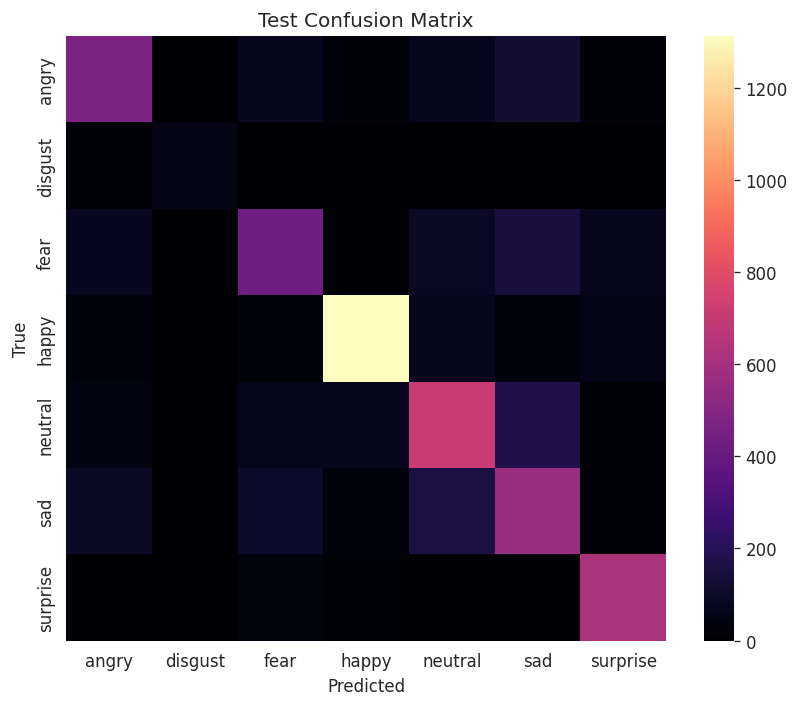

In [25]:
cm = confusion_matrix(all_true, all_preds, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=False, fmt="d", cmap="magma",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [26]:
def predict_image(img_path: str, model, transform=test_tfm, topk=3):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy().ravel()
    idxs = probs.argsort()[::-1][:topk]
    return [(CLASSES[i], float(probs[i])) for i in idxs]


In [27]:
import pandas as pd


history = pd.DataFrame(history)
history["ep"] = history["ep"].astype(int)

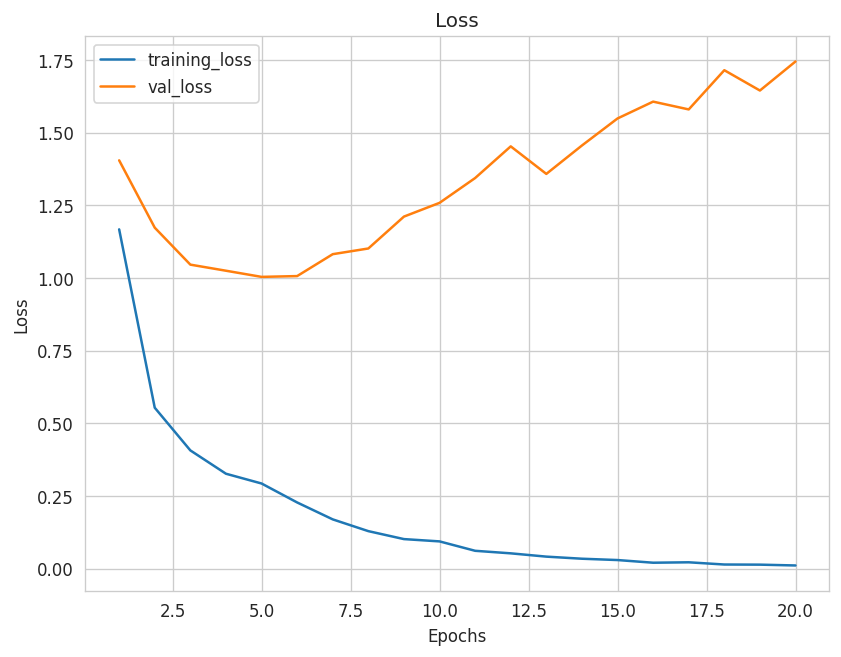

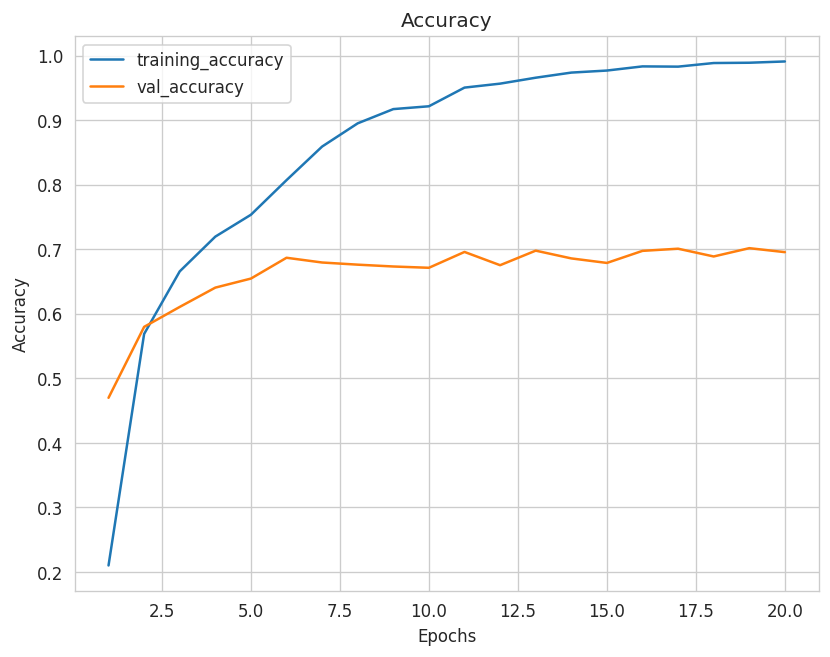

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(history["ep"], history["tr_loss"], label="training_loss")
plt.plot(history["ep"], history["va_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history["ep"], history["tr_acc"], label="training_accuracy")
plt.plot(history["ep"], history["va_acc"], label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
convnext_tiny_fb_in22k = max(history["va_acc"])
base_line = max(history_1.history['val_accuracy'])
mini_xception_algo = max(history_2.history['val_accuracy'])
random_forest = 0.48

NameError: name 'history_1' is not defined

In [ ]:
models = ['ConvNeXt Tiny FB-IN22K', 'Baseline CNN', 'Mini Xception', 'Random Forest']
accuracies = [convnext_tiny_fb_in22k, base_line, mini_xception_algo, random_forest]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies)

plt.ylabel('Validation Accuracy')
plt.title('Model Validation Accuracy Comparison')
plt.ylim(0, 1)  

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.show()


In [ ]:
import torch

# Example: your trained model
model = MyModel()
model.load_state_dict(torch.load("model_weights.pth", map_location="cpu"))
model.eval()


In [ ]:
# Example: if your model expects 1x3x224x224 (batch_size=1, 3 color channels, 224x224 image)
dummy_input = torch.randn(1, 3, 224, 224)


In [ ]:
torch.onnx.export(
    model,                    # your model
    dummy_input,               # dummy input
    "model.onnx",              # output file
    export_params=True,        # store trained weights inside the model file
    opset_version=17,          # ONNX version (16 or 17 recommended)
    do_constant_folding=True,  # optimize constants
    input_names=["input"],     # optional
    output_names=["output"],   # optional
    dynamic_axes={             # allow variable batch size
        "input": {0: "batch_size"},
        "output": {0: "batch_size"},
    }
)
print("✅ Model exported to model.onnx")


In [ ]:
import onnxruntime as ort
import numpy as np

ort_session = ort.InferenceSession("model.onnx")

# Run inference
input_data = np.random.randn(1, 3, 224, 224).astype(np.float32)
outputs = ort_session.run(None, {"input": input_data})

print(outputs)


In [35]:
pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 92.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [37]:
import torch
import timm
import numpy as np
import onnxruntime as ort

CKPT_PATH    = "best_model.pt"      # your file
BACKBONE     = "convnext_tiny.fb_in22k"
NUM_CLASSES  = 7                    # <-- set this to what you trained
DEVICE       = "cpu"                # export from CPU is safest/most portable

# 1) Rebuild the same model architecture
# Use pretrained=False here because you’ll load *your* fine-tuned weights next.
model = timm.create_model(
    BACKBONE,
    pretrained=False,
    num_classes=NUM_CLASSES
).to(DEVICE)
model.eval()

# 2) Load your state_dict robustly (handles common checkpoint layouts)
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)

# Common patterns: {"state_dict": {...}}, {"model": {...}}, or raw state_dict
if isinstance(ckpt, dict) and "state_dict" in ckpt:
    sd = ckpt["state_dict"]
elif isinstance(ckpt, dict) and "model" in ckpt:
    sd = ckpt["model"]
else:
    sd = ckpt  # assume it's already a flat state_dict

# Strip "module." prefix if saved from DataParallel/DistributedDataParallel
new_sd = {}
for k, v in sd.items():
    if k.startswith("module."):
        k = k[len("module."):]
    new_sd[k] = v

# Try strict load first; if it fails due to head mismatch, show keys and fallback
try:
    missing, unexpected = model.load_state_dict(new_sd, strict=False)
    if missing or unexpected:
        print("⚠️ load_state_dict warnings:")
        if missing:   print("  Missing keys:", missing)
        if unexpected:print("  Unexpected keys:", unexpected)
except Exception as e:
    print("❌ Failed to load state_dict strictly:", e)
    raise

# 3) Figure out the input size you trained with (timm stores defaults)
# If you trained on a different size, set IMG_SIZE accordingly.
cfg = getattr(model, "default_cfg", {}) or {}
input_size = cfg.get("input_size", (3, 224, 224))
C, H, W = input_size
IMG_SIZE = (H, W)   # (height, width)

# 4) Export to ONNX
dummy = torch.randn(1, C, H, W, device=DEVICE)

onnx_path = "model_basuru.onnx"
torch.onnx.export(
    model,
    dummy,
    onnx_path,
    export_params=True,
    opset_version=17,            # 16 or 17 is good; 17 is current-stable for most ops
    do_constant_folding=True,
    input_names=["input"],
    output_names=["logits"],     # before softmax; apply softmax in your runtime if needed
    dynamic_axes={
        "input":  {0: "batch_size"},  # variable batch
        "logits": {0: "batch_size"},
    },
)
print(f"✅ Exported to {onnx_path}")

# 5) Quick sanity check with ONNX Runtime
sess = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])

# If you ever forget the actual input name, read it:
inp_name = sess.get_inputs()[0].name
print("ONNX input name:", inp_name, "shape:", sess.get_inputs()[0].shape)

# Fake data (note: real inference must use the same preprocessing as training!)
x = np.random.randn(1, C, H, W).astype(np.float32)
y = sess.run(None, {inp_name: x})[0]
print("ONNX output shape:", y.shape)  # should be (1, NUM_CLASSES)


✅ Exported to model_basuru.onnx
ONNX input name: input shape: ['batch_size', 3, 224, 224]
ONNX output shape: (1, 7)


In [38]:
import json

class_dict = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

with open("classes.json", "w") as f:
    json.dump(class_dict, f, indent=4)
print("✅ classes.json created")


✅ classes.json created
